In [1]:
"""
Tutorial for the Million Song Dataset

by Thierry Bertin-Mahieux (2011) Columbia University
   tb2332@columbia.edu
   Copyright 2011 T. Bertin-Mahieux, All Rights Reserved

This tutorial will walk you through a quick experiment
using the Million Song Dataset (MSD). We will actually be working
on the 10K songs subset for speed issues, but the code should
transpose seamlessly.

In this tutorial, we do simple metadata analysis. We look at
which artist has the most songs by iterating over the whole
dataset and using an SQLite database.

You need to have the MSD code downloaded from GITHUB.
See the MSD website for details:
http://labrosa.ee.columbia.edu/millionsong/

If you have any questions regarding the dataset or this tutorial,
please first take a look at the website. Send us an email
if you haven't found the answer.

Note: this tutorial is developed using Python 2.6
      on an Ubuntu machine. PDF created using 'pyreport'.
"""

# usual imports
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np # get it at: http://numpy.scipy.org/
# path to the Million Song Dataset subset (uncompressed)
# CHANGE IT TO YOUR LOCAL CONFIGURATION
msd_subset_path='MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
assert os.path.isdir(msd_subset_path),'wrong path' # sanity check
# path to the Million Song Dataset code
# CHANGE IT TO YOUR LOCAL CONFIGURATION
# msd_code_path='/MillionSongSubset'
# assert os.path.isdir(msd_code_path),'wrong path' # sanity check
# # we add some paths to python so we can import MSD code
# # Ubuntu: you can change the environment variable PYTHONPATH
# # in your .bashrc file so you do not have to type these lines
# sys.path.append( os.path.join(msd_code_path,'PythonSrc') )

# imports specific to the MSD
import hdf5_getters as GETTERS

# the following function simply gives us a nice string for
# a time lag in seconds
def strtimedelta(starttime,stoptime):
    return str(datetime.timedelta(seconds=stoptime-starttime))

# we define this very useful function to iterate the files
def apply_to_all_files(basedir,func=lambda x: x,ext='.h5'):
    """
    From a base directory, go through all subdirectories,
    find all files with the given extension, apply the
    given function 'func' to all of them.
    If no 'func' is passed, we do nothing except counting.
    INPUT
       basedir  - base directory of the dataset
       func     - function to apply to all filenames
       ext      - extension, .h5 by default
    RETURN
       number of files
    """
    cnt = 0
    # iterate over all files in all subdirectories
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        # count files
        cnt += len(files)
        # apply function to all files
        for f in files :
            func(f)       
    return cnt

In [2]:
MFCC = []
track_ids = []
song_ids = []

def func_to_get_ids_and_timbre(filename):
    """
    This function does 3 simple things:
    - open the song file
    - get artist ID and put it
    - close the file
    """
    h5 = GETTERS.open_h5_file_read(filename)
    segments_timbre = GETTERS.get_segments_timbre(h5)
    track_id = GETTERS.get_track_id(h5)
    song_id = GETTERS.get_song_id(h5)
    MFCC.append( segments_timbre )
    track_ids.append( track_id )
    song_ids.append( song_id )
    
    h5.close()

apply_to_all_files(msd_subset_data_path,func=func_to_get_ids_and_timbre)

10000

In [3]:
song_ids_clean = [ str(sid)[2:-1] for sid in song_ids ]
track_ids_clean = [ str(tid)[2:-1] for tid in track_ids ]

In [4]:
ids = list(zip(song_ids_clean, track_ids_clean))

In [5]:
dataset = dict( zip ( ids , MFCC ))

In [6]:
dataset_track_mfcc = dict( zip( track_ids_clean, MFCC))

In [7]:
dataset_song_mfcc = dict( zip( song_ids_clean, MFCC ) )

In [8]:
import pandas as pd

test_labels = pd.read_csv("deezer_mood_detection_dataset-master/test.csv")
train_labels = pd.read_csv("deezer_mood_detection_dataset-master/train.csv")
validate_labels = pd.read_csv("deezer_mood_detection_dataset-master/validation.csv")

In [9]:
labels = [test_labels, train_labels, validate_labels]
labels_df = pd.concat(labels)

In [10]:
labels_df.head()

,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name
0,532171,SOSDIDR12A8C130E5D,TRGVJCD128F42623E3,-0.420759,0.754644,Fiona Apple,Fast As You Can
1,532216,SOPMTTO12AB0183DB9,TRNXMAY128F931FAC6,-0.465330,0.011006,Fiona Apple,I Know
2,532284,SOQCEJU12A8C13220B,TRYMZQJ128F426A0E7,0.373325,-0.923151,Xzibit,Get Your Walk On
3,532989,SOLEFHR12D021B2A57,TRZHHIL128F4264EE0,0.894528,-0.390774,Fiona Apple,Extraordinary Machine
4,533164,SOFDPOX12A8C13780D,TRJEBIT128F933A400,-1.636900,-0.459145,Patty Loveless,How Can I Help You Say Goodbye


In [11]:
print(test_labels.shape)
print(train_labels.shape)
print(validate_labels.shape)

(3514, 7)
(11267, 7)
(3863, 7)


In [11]:
# song_ids_from_labels = labels_df.loc[ : , 'MSD_sng_id'].values
# track_ids_from_labels = labels_df.loc[ : , 'MSD_track_id'].values

In [13]:
def find_overlap_between_datasets( sid, tid, sid_label, tid_label ):
    i = 0
    indice_of_input_data = []
    indice_of_label_data = []
    
    for i in range(len(sid)):
        if sid[i] in sid_label:
            indice_of_input_data.append(i)
            indice_of_label_data.append(np.where(sid_label == sid[i])[0])
        elif tid[i] in tid_label:
            indice_of_input_data.append(i)
            indice_of_label_data.append(np.where(sid_label == sid[i])[0])
        else:
            pass
    
    return indice_of_input_data, indice_of_label_data

In [14]:
print(len(song_ids_clean))
print(len(track_ids_clean))
print(len(song_ids_from_labels))
print(len(track_ids_from_labels))

10000
10000
18644
18644


In [15]:
indices = find_overlap_between_datasets( song_ids_clean, 
                              track_ids_clean, 
                              song_ids_from_labels, 
                              track_ids_from_labels )

In [16]:
print( len(indices[0]) )
print( len(indices[1]) )

240
240


In [16]:
import pandas as pd

test_labels = pd.read_csv("deezer_mood_detection_dataset-master/test.csv")
train_labels = pd.read_csv("deezer_mood_detection_dataset-master/train.csv")
validate_labels = pd.read_csv("deezer_mood_detection_dataset-master/validation.csv")

labels = [test_labels, train_labels, validate_labels]
labels_df = pd.concat(labels)

deezer_ids = labels_df.loc[ : , 'dzr_sng_id'].values

In [48]:
deezer_ids[-1]

117581964

In [46]:
import requests
import json

base_url = 'https://api.deezer.com/track/'

dzr_id_url = {}
count = 0

for ids in deezer_ids : 
    result = requests.get( base_url + str(ids) )
    try:
        dzr_id_url[ids] = result.json()['preview']
    except:
        pass
    print("dzr id: ", ids, " url: ", dzr_id_url[ids])
    print( count )
    count += 1

dzr id:  532171  url:  
0
dzr id:  532216  url:  
1
dzr id:  532284  url:  
2
dzr id:  532989  url:  
3
dzr id:  533164  url:  
4
dzr id:  533922  url:  
5
dzr id:  533924  url:  
6
dzr id:  533925  url:  
7
dzr id:  534001  url:  
8
dzr id:  534268  url:  
9
dzr id:  534847  url:  
10
dzr id:  534850  url:  
11
dzr id:  534853  url:  
12
dzr id:  535204  url:  
13
dzr id:  536164  url:  
14
dzr id:  536979  url:  
15
dzr id:  538694  url:  
16
dzr id:  538700  url:  
17
dzr id:  539979  url:  
18
dzr id:  540944  url:  
19
dzr id:  540954  url:  
20
dzr id:  540956  url:  
21
dzr id:  540960  url:  
22
dzr id:  540967  url:  
23
dzr id:  541416  url:  
24
dzr id:  541830  url:  
25
dzr id:  541864  url:  
26
dzr id:  541867  url:  
27
dzr id:  541869  url:  
28
dzr id:  541870  url:  
29
dzr id:  541873  url:  
30
dzr id:  545027  url:  
31
dzr id:  545031  url:  
32
dzr id:  545375  url:  
33
dzr id:  545765  url:  
34
dzr id:  548327  url:  
35
dzr id:  548335  url:  
36
dzr id:  54

dzr id:  858229  url:  
297
dzr id:  858231  url:  
298
dzr id:  858233  url:  
299
dzr id:  858234  url:  
300
dzr id:  858594  url:  
301
dzr id:  858629  url:  
302
dzr id:  858848  url:  
303
dzr id:  859059  url:  
304
dzr id:  860486  url:  
305
dzr id:  860710  url:  
306
dzr id:  860711  url:  
307
dzr id:  860716  url:  
308
dzr id:  860717  url:  
309
dzr id:  862891  url:  
310
dzr id:  862893  url:  
311
dzr id:  862895  url:  
312
dzr id:  863163  url:  
313
dzr id:  863164  url:  
314
dzr id:  863166  url:  
315
dzr id:  863444  url:  
316
dzr id:  863867  url:  
317
dzr id:  864001  url:  
318
dzr id:  864002  url:  
319
dzr id:  864006  url:  
320
dzr id:  866280  url:  
321
dzr id:  866292  url:  
322
dzr id:  866295  url:  
323
dzr id:  866297  url:  
324
dzr id:  866396  url:  
325
dzr id:  866546  url:  
326
dzr id:  868852  url:  
327
dzr id:  868899  url:  
328
dzr id:  869309  url:  
329
dzr id:  869876  url:  
330
dzr id:  869877  url:  
331
dzr id:  869879  url

dzr id:  994232  url:  
591
dzr id:  994234  url:  
592
dzr id:  994427  url:  
593
dzr id:  994903  url:  
594
dzr id:  995501  url:  
595
dzr id:  995503  url:  
596
dzr id:  995784  url:  
597
dzr id:  995792  url:  
598
dzr id:  995817  url:  
599
dzr id:  1000698  url:  
600
dzr id:  1001580  url:  
601
dzr id:  1001586  url:  
602
dzr id:  1003351  url:  
603
dzr id:  1003356  url:  
604
dzr id:  1012614  url:  
605
dzr id:  1012821  url:  
606
dzr id:  1012947  url:  
607
dzr id:  1013229  url:  
608
dzr id:  1013231  url:  
609
dzr id:  1013232  url:  
610
dzr id:  1013511  url:  
611
dzr id:  1013820  url:  
612
dzr id:  1013873  url:  
613
dzr id:  1014287  url:  
614
dzr id:  1014536  url:  
615
dzr id:  1014587  url:  
616
dzr id:  1014772  url:  
617
dzr id:  1015545  url:  
618
dzr id:  1015580  url:  
619
dzr id:  1015978  url:  
620
dzr id:  1018021  url:  
621
dzr id:  1027110  url:  
622
dzr id:  1027112  url:  
623
dzr id:  1029092  url:  
624
dzr id:  1036745  url: 

dzr id:  1562578  url:  
874
dzr id:  1563683  url:  
875
dzr id:  1563789  url:  
876
dzr id:  1567556  url:  
877
dzr id:  1567841  url:  
878
dzr id:  1567845  url:  
879
dzr id:  1567848  url:  
880
dzr id:  1567850  url:  
881
dzr id:  1567854  url:  
882
dzr id:  1567860  url:  
883
dzr id:  1567862  url:  
884
dzr id:  1571374  url:  
885
dzr id:  1573798  url:  
886
dzr id:  1575521  url:  
887
dzr id:  1575527  url:  
888
dzr id:  1575994  url:  
889
dzr id:  1576210  url:  
890
dzr id:  1576222  url:  
891
dzr id:  1576236  url:  
892
dzr id:  1576240  url:  
893
dzr id:  1579476  url:  
894
dzr id:  1579660  url:  
895
dzr id:  1579681  url:  
896
dzr id:  1579755  url:  
897
dzr id:  1579756  url:  
898
dzr id:  1579759  url:  
899
dzr id:  1579763  url:  
900
dzr id:  1579768  url:  
901
dzr id:  1581706  url:  
902
dzr id:  1582834  url:  
903
dzr id:  1583138  url:  
904
dzr id:  1583158  url:  
905
dzr id:  1583395  url:  
906
dzr id:  1609782  url:  
907
dzr id:  16097

dzr id:  2423901  url:  
1153
dzr id:  2423902  url:  
1154
dzr id:  2423913  url:  
1155
dzr id:  2423921  url:  
1156
dzr id:  2423927  url:  
1157
dzr id:  2424751  url:  
1158
dzr id:  2424775  url:  
1159
dzr id:  2424781  url:  
1160
dzr id:  2428523  url:  
1161
dzr id:  2429767  url:  
1162
dzr id:  2431088  url:  
1163
dzr id:  2431283  url:  
1164
dzr id:  2431285  url:  
1165
dzr id:  2431286  url:  
1166
dzr id:  2431289  url:  
1167
dzr id:  2431290  url:  
1168
dzr id:  2431292  url:  
1169
dzr id:  2431293  url:  
1170
dzr id:  2431294  url:  
1171
dzr id:  2433261  url:  
1172
dzr id:  2438753  url:  
1173
dzr id:  2438756  url:  
1174
dzr id:  2440294  url:  
1175
dzr id:  2440471  url:  
1176
dzr id:  2440473  url:  
1177
dzr id:  2441442  url:  
1178
dzr id:  2443094  url:  
1179
dzr id:  2447315  url:  
1180
dzr id:  2451867  url:  
1181
dzr id:  2451871  url:  
1182
dzr id:  2451877  url:  
1183
dzr id:  2452708  url:  
1184
dzr id:  2453916  url:  
1185
dzr id:  2

dzr id:  3102133  url:  
1428
dzr id:  3102134  url:  
1429
dzr id:  3102135  url:  
1430
dzr id:  3102138  url:  
1431
dzr id:  3102139  url:  
1432
dzr id:  3102141  url:  
1433
dzr id:  3102144  url:  
1434
dzr id:  3102208  url:  
1435
dzr id:  3102209  url:  
1436
dzr id:  3102210  url:  
1437
dzr id:  3102211  url:  
1438
dzr id:  3102212  url:  
1439
dzr id:  3102214  url:  
1440
dzr id:  3102215  url:  
1441
dzr id:  3102217  url:  
1442
dzr id:  3104082  url:  
1443
dzr id:  3104704  url:  
1444
dzr id:  3104717  url:  
1445
dzr id:  3105149  url:  
1446
dzr id:  3105152  url:  
1447
dzr id:  3105153  url:  
1448
dzr id:  3105156  url:  
1449
dzr id:  3105157  url:  
1450
dzr id:  3105159  url:  
1451
dzr id:  3105288  url:  
1452
dzr id:  3105927  url:  
1453
dzr id:  3106426  url:  
1454
dzr id:  3106427  url:  
1455
dzr id:  3106431  url:  
1456
dzr id:  3107452  url:  
1457
dzr id:  3110618  url:  
1458
dzr id:  3110854  url:  
1459
dzr id:  3110856  url:  
1460
dzr id:  3

dzr id:  3672708  url:  
1703
dzr id:  3672967  url:  
1704
dzr id:  3672981  url:  
1705
dzr id:  3729794  url:  
1706
dzr id:  3730007  url:  
1707
dzr id:  3731613  url:  
1708
dzr id:  3731614  url:  
1709
dzr id:  3731615  url:  
1710
dzr id:  3731616  url:  
1711
dzr id:  3731617  url:  
1712
dzr id:  3731619  url:  
1713
dzr id:  3731621  url:  
1714
dzr id:  3732426  url:  
1715
dzr id:  3732428  url:  
1716
dzr id:  3734634  url:  
1717
dzr id:  3734803  url:  
1718
dzr id:  3746353  url:  
1719
dzr id:  3751801  url:  
1720
dzr id:  3754385  url:  
1721
dzr id:  3754881  url:  
1722
dzr id:  3754885  url:  
1723
dzr id:  3754889  url:  
1724
dzr id:  3760492  url:  
1725
dzr id:  3760497  url:  
1726
dzr id:  3780919  url:  
1727
dzr id:  3781914  url:  
1728
dzr id:  3781915  url:  
1729
dzr id:  3785085  url:  
1730
dzr id:  3835515  url:  
1731
dzr id:  3838281  url:  
1732
dzr id:  3839178  url:  
1733
dzr id:  3840678  url:  
1734
dzr id:  3844010  url:  
1735
dzr id:  3

dzr id:  5659786  url:  
1978
dzr id:  5659787  url:  
1979
dzr id:  5659789  url:  
1980
dzr id:  5779678  url:  
1981
dzr id:  5785654  url:  
1982
dzr id:  5785659  url:  
1983
dzr id:  5785662  url:  
1984
dzr id:  5785664  url:  
1985
dzr id:  5785665  url:  
1986
dzr id:  5785689  url:  
1987
dzr id:  5785693  url:  
1988
dzr id:  5785696  url:  
1989
dzr id:  5785701  url:  
1990
dzr id:  5785703  url:  
1991
dzr id:  5785705  url:  
1992
dzr id:  5785759  url:  
1993
dzr id:  5785765  url:  
1994
dzr id:  5785770  url:  
1995
dzr id:  5785855  url:  
1996
dzr id:  5785856  url:  
1997
dzr id:  5785857  url:  
1998
dzr id:  5785858  url:  
1999
dzr id:  5785859  url:  
2000
dzr id:  5785860  url:  
2001
dzr id:  5785861  url:  
2002
dzr id:  5785864  url:  
2003
dzr id:  5805004  url:  
2004
dzr id:  5816229  url:  
2005
dzr id:  5816766  url:  
2006
dzr id:  5816767  url:  
2007
dzr id:  5816772  url:  
2008
dzr id:  5816776  url:  
2009
dzr id:  5816778  url:  
2010
dzr id:  5

dzr id:  10958810  url:  
2251
dzr id:  10958821  url:  
2252
dzr id:  10958822  url:  
2253
dzr id:  10958826  url:  
2254
dzr id:  10958827  url:  
2255
dzr id:  10958838  url:  
2256
dzr id:  10970086  url:  
2257
dzr id:  10970401  url:  
2258
dzr id:  10972458  url:  
2259
dzr id:  10972693  url:  
2260
dzr id:  10972696  url:  
2261
dzr id:  10972697  url:  
2262
dzr id:  11012433  url:  
2263
dzr id:  11013108  url:  
2264
dzr id:  11013112  url:  
2265
dzr id:  11013117  url:  
2266
dzr id:  11013534  url:  
2267
dzr id:  11120042  url:  
2268
dzr id:  11120043  url:  
2269
dzr id:  11120052  url:  
2270
dzr id:  11125142  url:  
2271
dzr id:  11125153  url:  
2272
dzr id:  11125161  url:  
2273
dzr id:  11125163  url:  
2274
dzr id:  11126902  url:  
2275
dzr id:  11221315  url:  
2276
dzr id:  11221316  url:  
2277
dzr id:  11221317  url:  
2278
dzr id:  11272775  url:  
2279
dzr id:  11272777  url:  
2280
dzr id:  11272779  url:  
2281
dzr id:  11272782  url:  
2282
dzr id: 

dzr id:  14164249  url:  
2517
dzr id:  14164251  url:  
2518
dzr id:  14164423  url:  
2519
dzr id:  14228148  url:  
2520
dzr id:  14228151  url:  
2521
dzr id:  14228152  url:  
2522
dzr id:  14228153  url:  
2523
dzr id:  14228830  url:  
2524
dzr id:  14457250  url:  
2525
dzr id:  14457266  url:  
2526
dzr id:  14503311  url:  
2527
dzr id:  14514090  url:  
2528
dzr id:  14514091  url:  
2529
dzr id:  14514093  url:  
2530
dzr id:  14514095  url:  
2531
dzr id:  14514097  url:  
2532
dzr id:  14514100  url:  
2533
dzr id:  14514102  url:  
2534
dzr id:  14514104  url:  
2535
dzr id:  14514126  url:  
2536
dzr id:  14552021  url:  
2537
dzr id:  14553723  url:  
2538
dzr id:  14594622  url:  
2539
dzr id:  14610664  url:  
2540
dzr id:  14633046  url:  
2541
dzr id:  14653664  url:  
2542
dzr id:  14686864  url:  
2543
dzr id:  14687033  url:  
2544
dzr id:  14738292  url:  
2545
dzr id:  14738294  url:  
2546
dzr id:  14738295  url:  
2547
dzr id:  14738298  url:  
2548
dzr id: 

dzr id:  18082710  url:  
2782
dzr id:  18082711  url:  
2783
dzr id:  18083557  url:  
2784
dzr id:  18084044  url:  
2785
dzr id:  18090134  url:  
2786
dzr id:  18090704  url:  
2787
dzr id:  18093286  url:  
2788
dzr id:  18111921  url:  
2789
dzr id:  18121162  url:  
2790
dzr id:  18121165  url:  
2791
dzr id:  18126103  url:  
2792
dzr id:  18157418  url:  
2793
dzr id:  18157423  url:  
2794
dzr id:  18169053  url:  
2795
dzr id:  18529221  url:  
2796
dzr id:  19774001  url:  
2797
dzr id:  19774031  url:  
2798
dzr id:  19774051  url:  
2799
dzr id:  19774061  url:  
2800
dzr id:  19774071  url:  
2801
dzr id:  19783931  url:  
2802
dzr id:  19791381  url:  
2803
dzr id:  19791441  url:  
2804
dzr id:  19791471  url:  
2805
dzr id:  19862891  url:  
2806
dzr id:  19863771  url:  
2807
dzr id:  20012901  url:  
2808
dzr id:  20016341  url:  
2809
dzr id:  20064821  url:  
2810
dzr id:  20064851  url:  
2811
dzr id:  20065851  url:  
2812
dzr id:  20097301  url:  
2813
dzr id: 

dzr id:  68058134  url:  
3047
dzr id:  68240266  url:  
3048
dzr id:  68240273  url:  
3049
dzr id:  68760352  url:  
3050
dzr id:  68924757  url:  
3051
dzr id:  68925180  url:  
3052
dzr id:  68925185  url:  
3053
dzr id:  68925186  url:  
3054
dzr id:  68925551  url:  
3055
dzr id:  68925554  url:  
3056
dzr id:  68925557  url:  
3057
dzr id:  68925560  url:  
3058
dzr id:  68925577  url:  
3059
dzr id:  68925584  url:  
3060
dzr id:  68925585  url:  
3061
dzr id:  68925586  url:  
3062
dzr id:  68925588  url:  
3063
dzr id:  68925673  url:  
3064
dzr id:  68925814  url:  
3065
dzr id:  68925948  url:  
3066
dzr id:  68926147  url:  
3067
dzr id:  68926148  url:  
3068
dzr id:  68926152  url:  
3069
dzr id:  68926156  url:  
3070
dzr id:  68926342  url:  
3071
dzr id:  68926343  url:  
3072
dzr id:  68926346  url:  
3073
dzr id:  68926432  url:  
3074
dzr id:  69000286  url:  
3075
dzr id:  69000292  url:  
3076
dzr id:  69000468  url:  
3077
dzr id:  69000473  url:  
3078
dzr id: 

dzr id:  82153190  url:  
3312
dzr id:  82153192  url:  
3313
dzr id:  82153194  url:  
3314
dzr id:  82265240  url:  
3315
dzr id:  82265248  url:  
3316
dzr id:  82293022  url:  
3317
dzr id:  82298506  url:  
3318
dzr id:  82300646  url:  
3319
dzr id:  83007448  url:  
3320
dzr id:  83007452  url:  
3321
dzr id:  83729202  url:  
3322
dzr id:  83945139  url:  
3323
dzr id:  83945145  url:  
3324
dzr id:  83971949  url:  
3325
dzr id:  84007245  url:  
3326
dzr id:  84311365  url:  
3327
dzr id:  84791223  url:  
3328
dzr id:  84841989  url:  
3329
dzr id:  84841993  url:  
3330
dzr id:  84841995  url:  
3331
dzr id:  84841997  url:  
3332
dzr id:  84842003  url:  
3333
dzr id:  84842005  url:  
3334
dzr id:  84842013  url:  
3335
dzr id:  84842017  url:  
3336
dzr id:  84969923  url:  
3337
dzr id:  85144068  url:  
3338
dzr id:  85190766  url:  
3339
dzr id:  85239154  url:  
3340
dzr id:  85381880  url:  
3341
dzr id:  85381892  url:  
3342
dzr id:  85488882  url:  
3343
dzr id: 

dzr id:  540175  url:  
3580
dzr id:  540177  url:  
3581
dzr id:  540178  url:  
3582
dzr id:  540180  url:  
3583
dzr id:  540181  url:  
3584
dzr id:  540182  url:  
3585
dzr id:  540185  url:  
3586
dzr id:  540186  url:  
3587
dzr id:  540191  url:  
3588
dzr id:  540193  url:  
3589
dzr id:  540196  url:  
3590
dzr id:  540203  url:  
3591
dzr id:  540588  url:  
3592
dzr id:  540732  url:  
3593
dzr id:  541012  url:  
3594
dzr id:  541013  url:  
3595
dzr id:  541016  url:  
3596
dzr id:  541020  url:  
3597
dzr id:  541025  url:  
3598
dzr id:  541101  url:  
3599
dzr id:  541393  url:  
3600
dzr id:  541403  url:  
3601
dzr id:  541855  url:  
3602
dzr id:  541959  url:  
3603
dzr id:  541961  url:  
3604
dzr id:  541962  url:  
3605
dzr id:  544934  url:  
3606
dzr id:  545245  url:  
3607
dzr id:  545253  url:  
3608
dzr id:  545493  url:  
3609
dzr id:  546089  url:  
3610
dzr id:  546090  url:  
3611
dzr id:  546130  url:  
3612
dzr id:  546371  url:  
3613
dzr id:  54657

dzr id:  596985  url:  
3864
dzr id:  597011  url:  
3865
dzr id:  597166  url:  
3866
dzr id:  597189  url:  
3867
dzr id:  597801  url:  
3868
dzr id:  597899  url:  
3869
dzr id:  598057  url:  
3870
dzr id:  598067  url:  
3871
dzr id:  598766  url:  
3872
dzr id:  598768  url:  
3873
dzr id:  598773  url:  
3874
dzr id:  598777  url:  
3875
dzr id:  598782  url:  
3876
dzr id:  598786  url:  
3877
dzr id:  599205  url:  
3878
dzr id:  599207  url:  
3879
dzr id:  599302  url:  
3880
dzr id:  600153  url:  
3881
dzr id:  600156  url:  
3882
dzr id:  600173  url:  
3883
dzr id:  600656  url:  
3884
dzr id:  600797  url:  
3885
dzr id:  601017  url:  
3886
dzr id:  601626  url:  
3887
dzr id:  601659  url:  
3888
dzr id:  601791  url:  
3889
dzr id:  604032  url:  
3890
dzr id:  604154  url:  
3891
dzr id:  604315  url:  
3892
dzr id:  604401  url:  
3893
dzr id:  605011  url:  
3894
dzr id:  605281  url:  
3895
dzr id:  605870  url:  
3896
dzr id:  605910  url:  
3897
dzr id:  60699

dzr id:  635114  url:  
4147
dzr id:  635580  url:  
4148
dzr id:  637361  url:  
4149
dzr id:  637372  url:  
4150
dzr id:  637376  url:  
4151
dzr id:  638591  url:  
4152
dzr id:  660481  url:  
4153
dzr id:  660645  url:  
4154
dzr id:  660647  url:  
4155
dzr id:  660936  url:  
4156
dzr id:  660937  url:  
4157
dzr id:  660938  url:  
4158
dzr id:  660940  url:  
4159
dzr id:  660941  url:  
4160
dzr id:  660942  url:  
4161
dzr id:  660943  url:  
4162
dzr id:  660944  url:  
4163
dzr id:  660945  url:  
4164
dzr id:  661912  url:  
4165
dzr id:  662099  url:  
4166
dzr id:  663202  url:  
4167
dzr id:  663203  url:  
4168
dzr id:  664925  url:  
4169
dzr id:  665064  url:  
4170
dzr id:  665219  url:  
4171
dzr id:  665365  url:  
4172
dzr id:  665373  url:  
4173
dzr id:  665391  url:  
4174
dzr id:  665690  url:  
4175
dzr id:  665719  url:  
4176
dzr id:  665978  url:  
4177
dzr id:  665981  url:  
4178
dzr id:  666258  url:  
4179
dzr id:  666648  url:  
4180
dzr id:  66709

dzr id:  785865  url:  
4430
dzr id:  785873  url:  
4431
dzr id:  785886  url:  
4432
dzr id:  786748  url:  
4433
dzr id:  786782  url:  
4434
dzr id:  787368  url:  
4435
dzr id:  788945  url:  
4436
dzr id:  788952  url:  
4437
dzr id:  788974  url:  
4438
dzr id:  789096  url:  
4439
dzr id:  791182  url:  
4440
dzr id:  791202  url:  
4441
dzr id:  791447  url:  
4442
dzr id:  794652  url:  
4443
dzr id:  795677  url:  
4444
dzr id:  796114  url:  
4445
dzr id:  796185  url:  
4446
dzr id:  796598  url:  
4447
dzr id:  797257  url:  
4448
dzr id:  797264  url:  
4449
dzr id:  797270  url:  
4450
dzr id:  797276  url:  
4451
dzr id:  797280  url:  
4452
dzr id:  797285  url:  
4453
dzr id:  797293  url:  
4454
dzr id:  797301  url:  
4455
dzr id:  797306  url:  
4456
dzr id:  797324  url:  
4457
dzr id:  800514  url:  
4458
dzr id:  800963  url:  
4459
dzr id:  801028  url:  
4460
dzr id:  801831  url:  
4461
dzr id:  805044  url:  
4462
dzr id:  805051  url:  
4463
dzr id:  80506

dzr id:  884234  url:  
4713
dzr id:  884238  url:  
4714
dzr id:  884239  url:  
4715
dzr id:  884241  url:  
4716
dzr id:  884391  url:  
4717
dzr id:  884393  url:  
4718
dzr id:  884394  url:  
4719
dzr id:  884397  url:  
4720
dzr id:  884398  url:  
4721
dzr id:  884400  url:  
4722
dzr id:  884406  url:  
4723
dzr id:  884695  url:  
4724
dzr id:  884701  url:  
4725
dzr id:  885160  url:  
4726
dzr id:  885167  url:  
4727
dzr id:  885186  url:  
4728
dzr id:  885187  url:  
4729
dzr id:  885191  url:  
4730
dzr id:  885192  url:  
4731
dzr id:  885197  url:  
4732
dzr id:  885204  url:  
4733
dzr id:  885440  url:  
4734
dzr id:  885672  url:  
4735
dzr id:  885679  url:  
4736
dzr id:  885683  url:  
4737
dzr id:  885686  url:  
4738
dzr id:  885691  url:  
4739
dzr id:  885918  url:  
4740
dzr id:  885965  url:  
4741
dzr id:  886740  url:  
4742
dzr id:  886991  url:  
4743
dzr id:  887029  url:  
4744
dzr id:  887092  url:  
4745
dzr id:  887096  url:  
4746
dzr id:  88789

dzr id:  938259  url:  
4997
dzr id:  939220  url:  
4998
dzr id:  939272  url:  
4999
dzr id:  939344  url:  
5000
dzr id:  939659  url:  
5001
dzr id:  939672  url:  
5002
dzr id:  939680  url:  
5003
dzr id:  939685  url:  
5004
dzr id:  939687  url:  
5005
dzr id:  939692  url:  
5006
dzr id:  939721  url:  
5007
dzr id:  939751  url:  
5008
dzr id:  939765  url:  
5009
dzr id:  939768  url:  
5010
dzr id:  939975  url:  
5011
dzr id:  940034  url:  
5012
dzr id:  940103  url:  
5013
dzr id:  940480  url:  
5014
dzr id:  940489  url:  
5015
dzr id:  940560  url:  
5016
dzr id:  940563  url:  
5017
dzr id:  940576  url:  
5018
dzr id:  940613  url:  
5019
dzr id:  940894  url:  
5020
dzr id:  940898  url:  
5021
dzr id:  940979  url:  
5022
dzr id:  940989  url:  
5023
dzr id:  940999  url:  
5024
dzr id:  941218  url:  
5025
dzr id:  941488  url:  
5026
dzr id:  941494  url:  
5027
dzr id:  941555  url:  
5028
dzr id:  941558  url:  
5029
dzr id:  941561  url:  
5030
dzr id:  94156

dzr id:  970642  url:  
5280
dzr id:  970692  url:  
5281
dzr id:  970693  url:  
5282
dzr id:  970694  url:  
5283
dzr id:  971004  url:  
5284
dzr id:  971227  url:  
5285
dzr id:  971339  url:  
5286
dzr id:  971637  url:  
5287
dzr id:  971639  url:  
5288
dzr id:  971644  url:  
5289
dzr id:  971648  url:  
5290
dzr id:  971650  url:  
5291
dzr id:  974332  url:  
5292
dzr id:  974845  url:  
5293
dzr id:  974987  url:  
5294
dzr id:  975144  url:  
5295
dzr id:  977947  url:  
5296
dzr id:  978796  url:  
5297
dzr id:  978797  url:  
5298
dzr id:  978799  url:  
5299
dzr id:  978800  url:  
5300
dzr id:  978801  url:  
5301
dzr id:  978803  url:  
5302
dzr id:  978820  url:  
5303
dzr id:  978821  url:  
5304
dzr id:  978823  url:  
5305
dzr id:  978828  url:  
5306
dzr id:  978831  url:  
5307
dzr id:  978963  url:  
5308
dzr id:  979015  url:  
5309
dzr id:  979356  url:  
5310
dzr id:  979357  url:  
5311
dzr id:  979358  url:  
5312
dzr id:  979361  url:  
5313
dzr id:  97936

dzr id:  1041531  url:  
5559
dzr id:  1043003  url:  
5560
dzr id:  1043270  url:  
5561
dzr id:  1043408  url:  
5562
dzr id:  1043423  url:  
5563
dzr id:  1043552  url:  
5564
dzr id:  1043576  url:  
5565
dzr id:  1043596  url:  
5566
dzr id:  1043648  url:  
5567
dzr id:  1043767  url:  
5568
dzr id:  1043773  url:  
5569
dzr id:  1043778  url:  
5570
dzr id:  1043780  url:  
5571
dzr id:  1043783  url:  
5572
dzr id:  1043786  url:  
5573
dzr id:  1043789  url:  
5574
dzr id:  1043792  url:  
5575
dzr id:  1043843  url:  
5576
dzr id:  1043859  url:  
5577
dzr id:  1043861  url:  
5578
dzr id:  1043992  url:  
5579
dzr id:  1043996  url:  
5580
dzr id:  1044124  url:  
5581
dzr id:  1044553  url:  
5582
dzr id:  1044555  url:  
5583
dzr id:  1044570  url:  
5584
dzr id:  1044840  url:  
5585
dzr id:  1045227  url:  
5586
dzr id:  1045413  url:  
5587
dzr id:  1045600  url:  
5588
dzr id:  1045628  url:  
5589
dzr id:  1046233  url:  
5590
dzr id:  1046705  url:  
5591
dzr id:  1

dzr id:  1115698  url:  
5833
dzr id:  1115705  url:  
5834
dzr id:  1115974  url:  
5835
dzr id:  1116013  url:  
5836
dzr id:  1116017  url:  
5837
dzr id:  1116040  url:  
5838
dzr id:  1116159  url:  
5839
dzr id:  1116166  url:  
5840
dzr id:  1116267  url:  
5841
dzr id:  1117191  url:  
5842
dzr id:  1118071  url:  
5843
dzr id:  1118460  url:  
5844
dzr id:  1119180  url:  
5845
dzr id:  1121706  url:  
5846
dzr id:  1122901  url:  
5847
dzr id:  1122903  url:  
5848
dzr id:  1122907  url:  
5849
dzr id:  1123690  url:  
5850
dzr id:  1123692  url:  
5851
dzr id:  1123698  url:  
5852
dzr id:  1123701  url:  
5853
dzr id:  1123737  url:  
5854
dzr id:  1123740  url:  
5855
dzr id:  1123844  url:  
5856
dzr id:  1123852  url:  
5857
dzr id:  1123859  url:  
5858
dzr id:  1123866  url:  
5859
dzr id:  1124261  url:  
5860
dzr id:  1124277  url:  
5861
dzr id:  1124281  url:  
5862
dzr id:  1124305  url:  
5863
dzr id:  1124308  url:  
5864
dzr id:  1124309  url:  
5865
dzr id:  1

dzr id:  1170929  url:  
6107
dzr id:  1170930  url:  
6108
dzr id:  1170932  url:  
6109
dzr id:  1170933  url:  
6110
dzr id:  1171871  url:  
6111
dzr id:  1171877  url:  
6112
dzr id:  1171880  url:  
6113
dzr id:  1172416  url:  
6114
dzr id:  1172425  url:  
6115
dzr id:  1172856  url:  
6116
dzr id:  1172877  url:  
6117
dzr id:  1172880  url:  
6118
dzr id:  1172881  url:  
6119
dzr id:  1172884  url:  
6120
dzr id:  1172886  url:  
6121
dzr id:  1172888  url:  
6122
dzr id:  1172913  url:  
6123
dzr id:  1172916  url:  
6124
dzr id:  1172918  url:  
6125
dzr id:  1172919  url:  
6126
dzr id:  1172920  url:  
6127
dzr id:  1172922  url:  
6128
dzr id:  1172924  url:  
6129
dzr id:  1173031  url:  
6130
dzr id:  1173533  url:  
6131
dzr id:  1173554  url:  
6132
dzr id:  1173976  url:  
6133
dzr id:  1174010  url:  
6134
dzr id:  1174073  url:  
6135
dzr id:  1174598  url:  
6136
dzr id:  1174599  url:  
6137
dzr id:  1174600  url:  
6138
dzr id:  1174601  url:  
6139
dzr id:  1

dzr id:  1580084  url:  
6382
dzr id:  1580138  url:  
6383
dzr id:  1580537  url:  
6384
dzr id:  1580844  url:  
6385
dzr id:  1580875  url:  
6386
dzr id:  1582168  url:  
6387
dzr id:  1582207  url:  
6388
dzr id:  1582208  url:  
6389
dzr id:  1582211  url:  
6390
dzr id:  1582214  url:  
6391
dzr id:  1582217  url:  
6392
dzr id:  1582221  url:  
6393
dzr id:  1582224  url:  
6394
dzr id:  1582255  url:  
6395
dzr id:  1582423  url:  
6396
dzr id:  1582438  url:  
6397
dzr id:  1582485  url:  
6398
dzr id:  1582493  url:  
6399
dzr id:  1582885  url:  
6400
dzr id:  1583246  url:  
6401
dzr id:  1583370  url:  
6402
dzr id:  1583375  url:  
6403
dzr id:  1584016  url:  
6404
dzr id:  1584238  url:  
6405
dzr id:  1584243  url:  
6406
dzr id:  1584245  url:  
6407
dzr id:  1584246  url:  
6408
dzr id:  1584248  url:  
6409
dzr id:  1584249  url:  
6410
dzr id:  1584251  url:  
6411
dzr id:  1584254  url:  
6412
dzr id:  1584256  url:  
6413
dzr id:  1584458  url:  
6414
dzr id:  1

dzr id:  2183171  url:  
6657
dzr id:  2183173  url:  
6658
dzr id:  2183830  url:  
6659
dzr id:  2185173  url:  
6660
dzr id:  2185174  url:  
6661
dzr id:  2188424  url:  
6662
dzr id:  2190532  url:  
6663
dzr id:  2190544  url:  
6664
dzr id:  2191385  url:  
6665
dzr id:  2191386  url:  
6666
dzr id:  2191387  url:  
6667
dzr id:  2191389  url:  
6668
dzr id:  2191390  url:  
6669
dzr id:  2191392  url:  
6670
dzr id:  2191393  url:  
6671
dzr id:  2191394  url:  
6672
dzr id:  2191395  url:  
6673
dzr id:  2191396  url:  
6674
dzr id:  2191760  url:  
6675
dzr id:  2192024  url:  
6676
dzr id:  2192035  url:  
6677
dzr id:  2192076  url:  
6678
dzr id:  2192084  url:  
6679
dzr id:  2192251  url:  
6680
dzr id:  2192549  url:  
6681
dzr id:  2192584  url:  
6682
dzr id:  2192593  url:  
6683
dzr id:  2192890  url:  
6684
dzr id:  2192893  url:  
6685
dzr id:  2192897  url:  
6686
dzr id:  2193499  url:  
6687
dzr id:  2193500  url:  
6688
dzr id:  2193545  url:  
6689
dzr id:  2

dzr id:  2292652  url:  
6932
dzr id:  2293144  url:  
6933
dzr id:  2293148  url:  
6934
dzr id:  2293164  url:  
6935
dzr id:  2293834  url:  
6936
dzr id:  2293835  url:  
6937
dzr id:  2293843  url:  
6938
dzr id:  2293844  url:  
6939
dzr id:  2293847  url:  
6940
dzr id:  2295293  url:  
6941
dzr id:  2295308  url:  
6942
dzr id:  2296095  url:  
6943
dzr id:  2296187  url:  
6944
dzr id:  2298087  url:  
6945
dzr id:  2298391  url:  
6946
dzr id:  2298577  url:  
6947
dzr id:  2298578  url:  
6948
dzr id:  2298582  url:  
6949
dzr id:  2298584  url:  
6950
dzr id:  2298587  url:  
6951
dzr id:  2300172  url:  
6952
dzr id:  2300683  url:  
6953
dzr id:  2300684  url:  
6954
dzr id:  2300686  url:  
6955
dzr id:  2300711  url:  
6956
dzr id:  2300786  url:  
6957
dzr id:  2300825  url:  
6958
dzr id:  2301402  url:  
6959
dzr id:  2301593  url:  
6960
dzr id:  2302519  url:  
6961
dzr id:  2302520  url:  
6962
dzr id:  2302522  url:  
6963
dzr id:  2303106  url:  
6964
dzr id:  2

dzr id:  2484999  url:  
7206
dzr id:  2485000  url:  
7207
dzr id:  2485003  url:  
7208
dzr id:  2485005  url:  
7209
dzr id:  2485007  url:  
7210
dzr id:  2485008  url:  
7211
dzr id:  2485009  url:  
7212
dzr id:  2485011  url:  
7213
dzr id:  2485118  url:  
7214
dzr id:  2485126  url:  
7215
dzr id:  2485128  url:  
7216
dzr id:  2485130  url:  
7217
dzr id:  2485991  url:  
7218
dzr id:  2487140  url:  
7219
dzr id:  2487141  url:  
7220
dzr id:  2487142  url:  
7221
dzr id:  2487147  url:  
7222
dzr id:  2487535  url:  
7223
dzr id:  2487572  url:  
7224
dzr id:  2487753  url:  
7225
dzr id:  2491663  url:  
7226
dzr id:  2495280  url:  
7227
dzr id:  2495710  url:  
7228
dzr id:  2495712  url:  
7229
dzr id:  2496217  url:  
7230
dzr id:  2496227  url:  
7231
dzr id:  2496822  url:  
7232
dzr id:  2497110  url:  
7233
dzr id:  2497875  url:  
7234
dzr id:  2497882  url:  
7235
dzr id:  2498525  url:  
7236
dzr id:  2498716  url:  
7237
dzr id:  2498759  url:  
7238
dzr id:  2

dzr id:  2555149  url:  
7480
dzr id:  2575685  url:  
7481
dzr id:  2575873  url:  
7482
dzr id:  2577092  url:  
7483
dzr id:  2577094  url:  
7484
dzr id:  2577095  url:  
7485
dzr id:  2577097  url:  
7486
dzr id:  2577357  url:  
7487
dzr id:  2577641  url:  
7488
dzr id:  2577955  url:  
7489
dzr id:  2580530  url:  
7490
dzr id:  2595112  url:  
7491
dzr id:  2595122  url:  
7492
dzr id:  2598229  url:  
7493
dzr id:  2598250  url:  
7494
dzr id:  2598546  url:  
7495
dzr id:  2599270  url:  
7496
dzr id:  2599274  url:  
7497
dzr id:  2599509  url:  
7498
dzr id:  2599759  url:  
7499
dzr id:  2599760  url:  
7500
dzr id:  2599766  url:  
7501
dzr id:  2600642  url:  
7502
dzr id:  2601055  url:  
7503
dzr id:  2602647  url:  
7504
dzr id:  2602768  url:  
7505
dzr id:  2603521  url:  
7506
dzr id:  2603525  url:  
7507
dzr id:  2603526  url:  
7508
dzr id:  2603776  url:  
7509
dzr id:  2603788  url:  
7510
dzr id:  2603793  url:  
7511
dzr id:  2603796  url:  
7512
dzr id:  2

dzr id:  2964044  url:  
7755
dzr id:  2964048  url:  
7756
dzr id:  2964252  url:  
7757
dzr id:  2964872  url:  
7758
dzr id:  2964882  url:  
7759
dzr id:  2971366  url:  
7760
dzr id:  2996666  url:  
7761
dzr id:  2996668  url:  
7762
dzr id:  2996672  url:  
7763
dzr id:  2996688  url:  
7764
dzr id:  2996707  url:  
7765
dzr id:  2996710  url:  
7766
dzr id:  3008735  url:  
7767
dzr id:  3009301  url:  
7768
dzr id:  3009302  url:  
7769
dzr id:  3009303  url:  
7770
dzr id:  3009304  url:  
7771
dzr id:  3010335  url:  
7772
dzr id:  3011587  url:  
7773
dzr id:  3011591  url:  
7774
dzr id:  3011594  url:  
7775
dzr id:  3011595  url:  
7776
dzr id:  3011596  url:  
7777
dzr id:  3011599  url:  
7778
dzr id:  3011600  url:  
7779
dzr id:  3011603  url:  
7780
dzr id:  3011646  url:  
7781
dzr id:  3011649  url:  
7782
dzr id:  3012220  url:  
7783
dzr id:  3015361  url:  
7784
dzr id:  3015365  url:  
7785
dzr id:  3015631  url:  
7786
dzr id:  3015635  url:  
7787
dzr id:  3

dzr id:  3110350  url:  
8029
dzr id:  3110353  url:  
8030
dzr id:  3110355  url:  
8031
dzr id:  3110356  url:  
8032
dzr id:  3110358  url:  
8033
dzr id:  3110364  url:  
8034
dzr id:  3110365  url:  
8035
dzr id:  3110439  url:  
8036
dzr id:  3110449  url:  
8037
dzr id:  3110450  url:  
8038
dzr id:  3110451  url:  
8039
dzr id:  3110453  url:  
8040
dzr id:  3111054  url:  
8041
dzr id:  3111059  url:  
8042
dzr id:  3111721  url:  
8043
dzr id:  3112315  url:  
8044
dzr id:  3112317  url:  
8045
dzr id:  3112319  url:  
8046
dzr id:  3112322  url:  
8047
dzr id:  3112324  url:  
8048
dzr id:  3112328  url:  
8049
dzr id:  3112351  url:  
8050
dzr id:  3112352  url:  
8051
dzr id:  3112354  url:  
8052
dzr id:  3112356  url:  
8053
dzr id:  3112713  url:  
8054
dzr id:  3112714  url:  
8055
dzr id:  3112716  url:  
8056
dzr id:  3112720  url:  
8057
dzr id:  3112726  url:  
8058
dzr id:  3112890  url:  
8059
dzr id:  3112891  url:  
8060
dzr id:  3112904  url:  
8061
dzr id:  3

dzr id:  3135629  url:  
8304
dzr id:  3135636  url:  
8305
dzr id:  3135638  url:  
8306
dzr id:  3135697  url:  
8307
dzr id:  3135701  url:  
8308
dzr id:  3135704  url:  
8309
dzr id:  3135706  url:  
8310
dzr id:  3135835  url:  
8311
dzr id:  3136054  url:  
8312
dzr id:  3136070  url:  
8313
dzr id:  3136549  url:  
8314
dzr id:  3136550  url:  
8315
dzr id:  3136643  url:  
8316
dzr id:  3136908  url:  
8317
dzr id:  3137680  url:  
8318
dzr id:  3137682  url:  
8319
dzr id:  3137689  url:  
8320
dzr id:  3137692  url:  
8321
dzr id:  3137988  url:  
8322
dzr id:  3137989  url:  
8323
dzr id:  3137990  url:  
8324
dzr id:  3137991  url:  
8325
dzr id:  3137996  url:  
8326
dzr id:  3137999  url:  
8327
dzr id:  3138042  url:  
8328
dzr id:  3138043  url:  
8329
dzr id:  3138045  url:  
8330
dzr id:  3138180  url:  
8331
dzr id:  3138374  url:  
8332
dzr id:  3138375  url:  
8333
dzr id:  3138376  url:  
8334
dzr id:  3138377  url:  
8335
dzr id:  3138379  url:  
8336
dzr id:  3

dzr id:  3231805  url:  
8579
dzr id:  3232921  url:  
8580
dzr id:  3232927  url:  
8581
dzr id:  3233014  url:  
8582
dzr id:  3233046  url:  
8583
dzr id:  3233048  url:  
8584
dzr id:  3233913  url:  
8585
dzr id:  3233914  url:  
8586
dzr id:  3234133  url:  
8587
dzr id:  3235520  url:  
8588
dzr id:  3235725  url:  
8589
dzr id:  3239962  url:  
8590
dzr id:  3239964  url:  
8591
dzr id:  3240059  url:  
8592
dzr id:  3240067  url:  
8593
dzr id:  3240074  url:  
8594
dzr id:  3240482  url:  
8595
dzr id:  3240483  url:  
8596
dzr id:  3241495  url:  
8597
dzr id:  3241496  url:  
8598
dzr id:  3241500  url:  
8599
dzr id:  3245983  url:  
8600
dzr id:  3247749  url:  
8601
dzr id:  3247753  url:  
8602
dzr id:  3247788  url:  
8603
dzr id:  3247870  url:  
8604
dzr id:  3247871  url:  
8605
dzr id:  3247874  url:  
8606
dzr id:  3247877  url:  
8607
dzr id:  3247881  url:  
8608
dzr id:  3247909  url:  
8609
dzr id:  3248240  url:  
8610
dzr id:  3248376  url:  
8611
dzr id:  3

dzr id:  3414688  url:  
8854
dzr id:  3414899  url:  
8855
dzr id:  3414900  url:  
8856
dzr id:  3414907  url:  
8857
dzr id:  3414908  url:  
8858
dzr id:  3415686  url:  
8859
dzr id:  3417069  url:  
8860
dzr id:  3417655  url:  
8861
dzr id:  3421242  url:  
8862
dzr id:  3424033  url:  
8863
dzr id:  3424749  url:  
8864
dzr id:  3425155  url:  
8865
dzr id:  3425157  url:  
8866
dzr id:  3426952  url:  
8867
dzr id:  3429052  url:  
8868
dzr id:  3430653  url:  
8869
dzr id:  3434204  url:  
8870
dzr id:  3434207  url:  
8871
dzr id:  3436851  url:  
8872
dzr id:  3437898  url:  
8873
dzr id:  3437909  url:  
8874
dzr id:  3440379  url:  
8875
dzr id:  3440380  url:  
8876
dzr id:  3440388  url:  
8877
dzr id:  3440394  url:  
8878
dzr id:  3440395  url:  
8879
dzr id:  3440396  url:  
8880
dzr id:  3440945  url:  
8881
dzr id:  3441315  url:  
8882
dzr id:  3441316  url:  
8883
dzr id:  3441321  url:  
8884
dzr id:  3441322  url:  
8885
dzr id:  3441326  url:  
8886
dzr id:  3

dzr id:  3824585  url:  
9129
dzr id:  3824717  url:  
9130
dzr id:  3826545  url:  
9131
dzr id:  3826648  url:  
9132
dzr id:  3826720  url:  
9133
dzr id:  3834279  url:  
9134
dzr id:  3834282  url:  
9135
dzr id:  3834284  url:  
9136
dzr id:  3834627  url:  
9137
dzr id:  3836813  url:  
9138
dzr id:  3837315  url:  
9139
dzr id:  3837324  url:  
9140
dzr id:  3837331  url:  
9141
dzr id:  3837646  url:  
9142
dzr id:  3838372  url:  
9143
dzr id:  3839150  url:  
9144
dzr id:  3839151  url:  
9145
dzr id:  3839152  url:  
9146
dzr id:  3839154  url:  
9147
dzr id:  3842080  url:  
9148
dzr id:  3843166  url:  
9149
dzr id:  3844226  url:  
9150
dzr id:  3845548  url:  
9151
dzr id:  3845783  url:  
9152
dzr id:  3846949  url:  
9153
dzr id:  3847545  url:  
9154
dzr id:  3847838  url:  
9155
dzr id:  3848623  url:  
9156
dzr id:  3848625  url:  
9157
dzr id:  3848923  url:  
9158
dzr id:  3850989  url:  
9159
dzr id:  3850990  url:  
9160
dzr id:  3854146  url:  
9161
dzr id:  3

dzr id:  4244855  url:  
9403
dzr id:  4244857  url:  
9404
dzr id:  4244861  url:  
9405
dzr id:  4244863  url:  
9406
dzr id:  4244865  url:  
9407
dzr id:  4246525  url:  
9408
dzr id:  4246527  url:  
9409
dzr id:  4247270  url:  
9410
dzr id:  4247662  url:  
9411
dzr id:  4252998  url:  
9412
dzr id:  4253186  url:  
9413
dzr id:  4253187  url:  
9414
dzr id:  4253188  url:  
9415
dzr id:  4253392  url:  
9416
dzr id:  4253442  url:  
9417
dzr id:  4253537  url:  
9418
dzr id:  4253581  url:  
9419
dzr id:  4254289  url:  
9420
dzr id:  4254290  url:  
9421
dzr id:  4254475  url:  
9422
dzr id:  4255666  url:  
9423
dzr id:  4255668  url:  
9424
dzr id:  4255669  url:  
9425
dzr id:  4255675  url:  
9426
dzr id:  4255676  url:  
9427
dzr id:  4255739  url:  
9428
dzr id:  4255888  url:  
9429
dzr id:  4256905  url:  
9430
dzr id:  4262283  url:  
9431
dzr id:  4262321  url:  
9432
dzr id:  4262331  url:  
9433
dzr id:  4262623  url:  
9434
dzr id:  4268004  url:  
9435
dzr id:  4

dzr id:  4677995  url:  
9677
dzr id:  4678000  url:  
9678
dzr id:  4679100  url:  
9679
dzr id:  4679139  url:  
9680
dzr id:  4686565  url:  
9681
dzr id:  4686788  url:  
9682
dzr id:  4687798  url:  
9683
dzr id:  4689001  url:  
9684
dzr id:  4689002  url:  
9685
dzr id:  4689012  url:  
9686
dzr id:  4689055  url:  
9687
dzr id:  4689058  url:  
9688
dzr id:  4689092  url:  
9689
dzr id:  4689207  url:  
9690
dzr id:  4689242  url:  
9691
dzr id:  4693061  url:  
9692
dzr id:  4695893  url:  
9693
dzr id:  4695895  url:  
9694
dzr id:  4695905  url:  
9695
dzr id:  4695907  url:  
9696
dzr id:  4695911  url:  
9697
dzr id:  4695913  url:  
9698
dzr id:  4706906  url:  
9699
dzr id:  4707908  url:  
9700
dzr id:  4707909  url:  
9701
dzr id:  4707910  url:  
9702
dzr id:  4707918  url:  
9703
dzr id:  4707919  url:  
9704
dzr id:  4708756  url:  
9705
dzr id:  4708757  url:  
9706
dzr id:  4708774  url:  
9707
dzr id:  4708802  url:  
9708
dzr id:  4708842  url:  
9709
dzr id:  4

dzr id:  5838200  url:  
9951
dzr id:  5884403  url:  
9952
dzr id:  5884448  url:  
9953
dzr id:  5884493  url:  
9954
dzr id:  5884802  url:  
9955
dzr id:  5886349  url:  
9956
dzr id:  5886352  url:  
9957
dzr id:  5886364  url:  
9958
dzr id:  5895560  url:  
9959
dzr id:  5899238  url:  
9960
dzr id:  5902858  url:  
9961
dzr id:  5902871  url:  
9962
dzr id:  5918816  url:  
9963
dzr id:  5936255  url:  
9964
dzr id:  5959427  url:  
9965
dzr id:  5959447  url:  
9966
dzr id:  5959448  url:  
9967
dzr id:  5990677  url:  
9968
dzr id:  6025488  url:  
9969
dzr id:  6025530  url:  
9970
dzr id:  6025732  url:  
9971
dzr id:  6025733  url:  
9972
dzr id:  6025743  url:  
9973
dzr id:  6025771  url:  
9974
dzr id:  6025779  url:  
9975
dzr id:  6025780  url:  
9976
dzr id:  6025786  url:  
9977
dzr id:  6025821  url:  
9978
dzr id:  6025919  url:  
9979
dzr id:  6025935  url:  
9980
dzr id:  6025980  url:  
9981
dzr id:  6026115  url:  
9982
dzr id:  6063750  url:  
9983
dzr id:  6

dzr id:  7193834  url:  
10217
dzr id:  7226745  url:  
10218
dzr id:  7230214  url:  
10219
dzr id:  7230215  url:  
10220
dzr id:  7230224  url:  
10221
dzr id:  7230238  url:  
10222
dzr id:  7230239  url:  
10223
dzr id:  7239019  url:  
10224
dzr id:  7239337  url:  
10225
dzr id:  7239826  url:  
10226
dzr id:  7245604  url:  
10227
dzr id:  7245725  url:  
10228
dzr id:  7254737  url:  
10229
dzr id:  7255222  url:  
10230
dzr id:  7255224  url:  
10231
dzr id:  7255541  url:  
10232
dzr id:  7255545  url:  
10233
dzr id:  7255547  url:  
10234
dzr id:  7255842  url:  
10235
dzr id:  7256042  url:  
10236
dzr id:  7256044  url:  
10237
dzr id:  7256045  url:  
10238
dzr id:  7256046  url:  
10239
dzr id:  7256047  url:  
10240
dzr id:  7256049  url:  
10241
dzr id:  7256050  url:  
10242
dzr id:  7256051  url:  
10243
dzr id:  7256053  url:  
10244
dzr id:  7256061  url:  
10245
dzr id:  7256265  url:  
10246
dzr id:  7256505  url:  
10247
dzr id:  7256515  url:  
10248
dzr id: 

dzr id:  8099045  url:  
10483
dzr id:  8099049  url:  
10484
dzr id:  8107693  url:  
10485
dzr id:  8112359  url:  
10486
dzr id:  8112382  url:  
10487
dzr id:  8139862  url:  
10488
dzr id:  8146784  url:  
10489
dzr id:  8146960  url:  
10490
dzr id:  8163842  url:  
10491
dzr id:  8164629  url:  
10492
dzr id:  8164641  url:  
10493
dzr id:  8164643  url:  
10494
dzr id:  8164647  url:  
10495
dzr id:  8164651  url:  
10496
dzr id:  8164652  url:  
10497
dzr id:  8164653  url:  
10498
dzr id:  8164655  url:  
10499
dzr id:  8164778  url:  
10500
dzr id:  8164941  url:  
10501
dzr id:  8164943  url:  
10502
dzr id:  8164945  url:  
10503
dzr id:  8238018  url:  
10504
dzr id:  8238022  url:  
10505
dzr id:  8238028  url:  
10506
dzr id:  8483244  url:  
10507
dzr id:  8483245  url:  
10508
dzr id:  8930812  url:  
10509
dzr id:  8931221  url:  
10510
dzr id:  9301356  url:  
10511
dzr id:  9576317  url:  
10512
dzr id:  9675875  url:  
10513
dzr id:  9710655  url:  
10514
dzr id: 

dzr id:  11013252  url:  
10741
dzr id:  11020990  url:  
10742
dzr id:  11032523  url:  
10743
dzr id:  11034039  url:  
10744
dzr id:  11058469  url:  
10745
dzr id:  11061260  url:  
10746
dzr id:  11061264  url:  
10747
dzr id:  11065655  url:  
10748
dzr id:  11075105  url:  
10749
dzr id:  11076099  url:  
10750
dzr id:  11091427  url:  
10751
dzr id:  11104579  url:  
10752
dzr id:  11104582  url:  
10753
dzr id:  11124521  url:  
10754
dzr id:  11125061  url:  
10755
dzr id:  11125943  url:  
10756
dzr id:  11125945  url:  
10757
dzr id:  11126058  url:  
10758
dzr id:  11126061  url:  
10759
dzr id:  11129098  url:  
10760
dzr id:  11186374  url:  
10761
dzr id:  11186466  url:  
10762
dzr id:  11217028  url:  
10763
dzr id:  11233492  url:  
10764
dzr id:  11237986  url:  
10765
dzr id:  11301055  url:  
10766
dzr id:  11336580  url:  
10767
dzr id:  11336583  url:  
10768
dzr id:  11336584  url:  
10769
dzr id:  11357314  url:  
10770
dzr id:  11357320  url:  
10771
dzr id: 

dzr id:  13146773  url:  
10998
dzr id:  13146819  url:  
10999
dzr id:  13146847  url:  
11000
dzr id:  13146886  url:  
11001
dzr id:  13147254  url:  
11002
dzr id:  13147257  url:  
11003
dzr id:  13147897  url:  
11004
dzr id:  13148026  url:  
11005
dzr id:  13148328  url:  
11006
dzr id:  13148329  url:  
11007
dzr id:  13148330  url:  
11008
dzr id:  13148331  url:  
11009
dzr id:  13148332  url:  
11010
dzr id:  13148334  url:  
11011
dzr id:  13148336  url:  
11012
dzr id:  13148337  url:  
11013
dzr id:  13148338  url:  
11014
dzr id:  13148339  url:  
11015
dzr id:  13148340  url:  
11016
dzr id:  13148345  url:  
11017
dzr id:  13148368  url:  
11018
dzr id:  13148379  url:  
11019
dzr id:  13148382  url:  
11020
dzr id:  13149306  url:  
11021
dzr id:  13149417  url:  
11022
dzr id:  13149758  url:  
11023
dzr id:  13157903  url:  
11024
dzr id:  13158010  url:  
11025
dzr id:  13158218  url:  
11026
dzr id:  13158325  url:  
11027
dzr id:  13158326  url:  
11028
dzr id: 

dzr id:  13520995  url:  
11256
dzr id:  13536629  url:  
11257
dzr id:  13547532  url:  
11258
dzr id:  13549175  url:  
11259
dzr id:  13549197  url:  
11260
dzr id:  13549394  url:  
11261
dzr id:  13549398  url:  
11262
dzr id:  13556661  url:  
11263
dzr id:  13556912  url:  
11264
dzr id:  13558992  url:  
11265
dzr id:  13560488  url:  
11266
dzr id:  13560504  url:  
11267
dzr id:  13560507  url:  
11268
dzr id:  13560515  url:  
11269
dzr id:  13560517  url:  
11270
dzr id:  13564105  url:  
11271
dzr id:  13569188  url:  
11272
dzr id:  13569192  url:  
11273
dzr id:  13569202  url:  
11274
dzr id:  13569238  url:  
11275
dzr id:  13569354  url:  
11276
dzr id:  13569470  url:  
11277
dzr id:  13569476  url:  
11278
dzr id:  13569482  url:  
11279
dzr id:  13587124  url:  
11280
dzr id:  13588008  url:  
11281
dzr id:  13636684  url:  
11282
dzr id:  13636685  url:  
11283
dzr id:  13636686  url:  
11284
dzr id:  13636688  url:  
11285
dzr id:  13636689  url:  
11286
dzr id: 

dzr id:  14659248  url:  
11513
dzr id:  14659637  url:  
11514
dzr id:  14676812  url:  
11515
dzr id:  14682589  url:  
11516
dzr id:  14737669  url:  
11517
dzr id:  14737670  url:  
11518
dzr id:  14737674  url:  
11519
dzr id:  14737678  url:  
11520
dzr id:  14748019  url:  
11521
dzr id:  14784307  url:  
11522
dzr id:  14784397  url:  
11523
dzr id:  14853916  url:  
11524
dzr id:  14853941  url:  
11525
dzr id:  14853945  url:  
11526
dzr id:  14853997  url:  
11527
dzr id:  14853999  url:  
11528
dzr id:  14874837  url:  
11529
dzr id:  14874847  url:  
11530
dzr id:  14875919  url:  
11531
dzr id:  14875978  url:  
11532
dzr id:  14875979  url:  
11533
dzr id:  14875996  url:  
11534
dzr id:  14875999  url:  
11535
dzr id:  14876007  url:  
11536
dzr id:  14876009  url:  
11537
dzr id:  14880760  url:  
11538
dzr id:  14880812  url:  
11539
dzr id:  14881316  url:  
11540
dzr id:  14881331  url:  
11541
dzr id:  14882234  url:  
11542
dzr id:  14884952  url:  
11543
dzr id: 

dzr id:  15539074  url:  
11771
dzr id:  15543677  url:  
11772
dzr id:  15557417  url:  
11773
dzr id:  15584002  url:  
11774
dzr id:  15586252  url:  
11775
dzr id:  15586294  url:  
11776
dzr id:  15586296  url:  
11777
dzr id:  15586310  url:  
11778
dzr id:  15586346  url:  
11779
dzr id:  15586369  url:  
11780
dzr id:  15586400  url:  
11781
dzr id:  15586422  url:  
11782
dzr id:  15586428  url:  
11783
dzr id:  15587091  url:  
11784
dzr id:  15587113  url:  
11785
dzr id:  15587468  url:  
11786
dzr id:  15587472  url:  
11787
dzr id:  15587477  url:  
11788
dzr id:  15587478  url:  
11789
dzr id:  15588499  url:  
11790
dzr id:  15588597  url:  
11791
dzr id:  15589182  url:  
11792
dzr id:  15589188  url:  
11793
dzr id:  15589769  url:  
11794
dzr id:  15589893  url:  
11795
dzr id:  15589896  url:  
11796
dzr id:  15589897  url:  
11797
dzr id:  15589899  url:  
11798
dzr id:  15592118  url:  
11799
dzr id:  15593560  url:  
11800
dzr id:  15593565  url:  
11801
dzr id: 

dzr id:  17608009  url:  
12029
dzr id:  17609384  url:  
12030
dzr id:  17609422  url:  
12031
dzr id:  17610473  url:  
12032
dzr id:  17610485  url:  
12033
dzr id:  17610664  url:  
12034
dzr id:  17611031  url:  
12035
dzr id:  17613285  url:  
12036
dzr id:  17613430  url:  
12037
dzr id:  17615653  url:  
12038
dzr id:  17615659  url:  
12039
dzr id:  17633080  url:  
12040
dzr id:  17633160  url:  
12041
dzr id:  17633342  url:  
12042
dzr id:  17634257  url:  
12043
dzr id:  17634278  url:  
12044
dzr id:  17634799  url:  
12045
dzr id:  17644937  url:  
12046
dzr id:  17670000  url:  
12047
dzr id:  17679567  url:  
12048
dzr id:  17679655  url:  
12049
dzr id:  17679761  url:  
12050
dzr id:  17680036  url:  
12051
dzr id:  17680123  url:  
12052
dzr id:  17680551  url:  
12053
dzr id:  17680613  url:  
12054
dzr id:  17680653  url:  
12055
dzr id:  17681533  url:  
12056
dzr id:  17683943  url:  
12057
dzr id:  17683950  url:  
12058
dzr id:  17684845  url:  
12059
dzr id: 

dzr id:  18060469  url:  
12286
dzr id:  18060749  url:  
12287
dzr id:  18061090  url:  
12288
dzr id:  18061347  url:  
12289
dzr id:  18082155  url:  
12290
dzr id:  18082644  url:  
12291
dzr id:  18082645  url:  
12292
dzr id:  18083257  url:  
12293
dzr id:  18084059  url:  
12294
dzr id:  18084062  url:  
12295
dzr id:  18084064  url:  
12296
dzr id:  18084065  url:  
12297
dzr id:  18084066  url:  
12298
dzr id:  18084171  url:  
12299
dzr id:  18084175  url:  
12300
dzr id:  18084622  url:  
12301
dzr id:  18085829  url:  
12302
dzr id:  18091444  url:  
12303
dzr id:  18102513  url:  
12304
dzr id:  18102751  url:  
12305
dzr id:  18105614  url:  
12306
dzr id:  18108956  url:  
12307
dzr id:  18135303  url:  
12308
dzr id:  18144356  url:  
12309
dzr id:  18152420  url:  
12310
dzr id:  18160469  url:  
12311
dzr id:  18160470  url:  
12312
dzr id:  18160472  url:  
12313
dzr id:  18160473  url:  
12314
dzr id:  18160474  url:  
12315
dzr id:  18168273  url:  
12316
dzr id: 

dzr id:  40532571  url:  
12544
dzr id:  40983881  url:  
12545
dzr id:  40983941  url:  
12546
dzr id:  41050631  url:  
12547
dzr id:  42602251  url:  
12548
dzr id:  43173501  url:  
12549
dzr id:  43753171  url:  
12550
dzr id:  44056161  url:  
12551
dzr id:  44059001  url:  
12552
dzr id:  44059021  url:  
12553
dzr id:  44059031  url:  
12554
dzr id:  44059061  url:  
12555
dzr id:  45580831  url:  
12556
dzr id:  46226571  url:  
12557
dzr id:  46431821  url:  
12558
dzr id:  49512551  url:  
12559
dzr id:  50344041  url:  
12560
dzr id:  51155311  url:  
12561
dzr id:  53392741  url:  
12562
dzr id:  53555891  url:  
12563
dzr id:  53555921  url:  
12564
dzr id:  53555951  url:  
12565
dzr id:  53599241  url:  
12566
dzr id:  53599281  url:  
12567
dzr id:  53599301  url:  
12568
dzr id:  53599321  url:  
12569
dzr id:  53599331  url:  
12570
dzr id:  53999031  url:  
12571
dzr id:  53999051  url:  
12572
dzr id:  53999131  url:  
12573
dzr id:  54004521  url:  
12574
dzr id: 

dzr id:  62960883  url:  
12802
dzr id:  62961068  url:  
12803
dzr id:  62961069  url:  
12804
dzr id:  62972759  url:  
12805
dzr id:  62972766  url:  
12806
dzr id:  62972772  url:  
12807
dzr id:  62972776  url:  
12808
dzr id:  62989711  url:  
12809
dzr id:  63030893  url:  
12810
dzr id:  63158030  url:  
12811
dzr id:  63158033  url:  
12812
dzr id:  63226515  url:  
12813
dzr id:  63226516  url:  
12814
dzr id:  63227301  url:  
12815
dzr id:  63253838  url:  
12816
dzr id:  63253906  url:  
12817
dzr id:  63253977  url:  
12818
dzr id:  63253978  url:  
12819
dzr id:  63253982  url:  
12820
dzr id:  63253983  url:  
12821
dzr id:  63254095  url:  
12822
dzr id:  63264924  url:  
12823
dzr id:  63283839  url:  
12824
dzr id:  63283844  url:  
12825
dzr id:  63283845  url:  
12826
dzr id:  63339088  url:  
12827
dzr id:  63353213  url:  
12828
dzr id:  63353370  url:  
12829
dzr id:  63353701  url:  
12830
dzr id:  63359091  url:  
12831
dzr id:  63359096  url:  
12832
dzr id: 

dzr id:  67870133  url:  
13060
dzr id:  67928853  url:  
13061
dzr id:  67933012  url:  
13062
dzr id:  67933015  url:  
13063
dzr id:  67943080  url:  
13064
dzr id:  68075342  url:  
13065
dzr id:  68097793  url:  
13066
dzr id:  68101775  url:  
13067
dzr id:  68239967  url:  
13068
dzr id:  68308973  url:  
13069
dzr id:  68308976  url:  
13070
dzr id:  68308978  url:  
13071
dzr id:  68308985  url:  
13072
dzr id:  68310192  url:  
13073
dzr id:  68310193  url:  
13074
dzr id:  68356630  url:  
13075
dzr id:  68356631  url:  
13076
dzr id:  68356633  url:  
13077
dzr id:  68356638  url:  
13078
dzr id:  68356642  url:  
13079
dzr id:  68356643  url:  
13080
dzr id:  68414905  url:  
13081
dzr id:  68414906  url:  
13082
dzr id:  68414908  url:  
13083
dzr id:  68414913  url:  
13084
dzr id:  68414915  url:  
13085
dzr id:  68414917  url:  
13086
dzr id:  68458285  url:  
13087
dzr id:  68459317  url:  
13088
dzr id:  68513563  url:  
13089
dzr id:  68514297  url:  
13090
dzr id: 

dzr id:  70989347  url:  
13317
dzr id:  70989357  url:  
13318
dzr id:  70990349  url:  
13319
dzr id:  70990350  url:  
13320
dzr id:  70990370  url:  
13321
dzr id:  70990401  url:  
13322
dzr id:  70990636  url:  
13323
dzr id:  70991425  url:  
13324
dzr id:  70991426  url:  
13325
dzr id:  70991429  url:  
13326
dzr id:  70996748  url:  
13327
dzr id:  71067883  url:  
13328
dzr id:  71068015  url:  
13329
dzr id:  71092102  url:  
13330
dzr id:  71092106  url:  
13331
dzr id:  71092109  url:  
13332
dzr id:  71092110  url:  
13333
dzr id:  71092111  url:  
13334
dzr id:  71109138  url:  
13335
dzr id:  71124900  url:  
13336
dzr id:  71124907  url:  
13337
dzr id:  71124927  url:  
13338
dzr id:  71124928  url:  
13339
dzr id:  71127959  url:  
13340
dzr id:  71127960  url:  
13341
dzr id:  71127962  url:  
13342
dzr id:  71127965  url:  
13343
dzr id:  71127966  url:  
13344
dzr id:  71144135  url:  
13345
dzr id:  71149415  url:  
13346
dzr id:  71149416  url:  
13347
dzr id: 

dzr id:  74594874  url:  
13574
dzr id:  74594886  url:  
13575
dzr id:  74596695  url:  
13576
dzr id:  74596696  url:  
13577
dzr id:  74596700  url:  
13578
dzr id:  74596706  url:  
13579
dzr id:  74606436  url:  
13580
dzr id:  74659460  url:  
13581
dzr id:  74732894  url:  
13582
dzr id:  74732903  url:  
13583
dzr id:  74833499  url:  
13584
dzr id:  74859010  url:  
13585
dzr id:  75070226  url:  
13586
dzr id:  75070231  url:  
13587
dzr id:  75070408  url:  
13588
dzr id:  75146793  url:  
13589
dzr id:  75161059  url:  
13590
dzr id:  75161112  url:  
13591
dzr id:  75161116  url:  
13592
dzr id:  75161118  url:  
13593
dzr id:  75161125  url:  
13594
dzr id:  75161133  url:  
13595
dzr id:  75161136  url:  
13596
dzr id:  75161137  url:  
13597
dzr id:  75197244  url:  
13598
dzr id:  75197304  url:  
13599
dzr id:  75197305  url:  
13600
dzr id:  75197306  url:  
13601
dzr id:  75197308  url:  
13602
dzr id:  75197312  url:  
13603
dzr id:  75211209  url:  
13604
dzr id: 

dzr id:  78308008  url:  
13831
dzr id:  78322924  url:  
13832
dzr id:  78334456  url:  
13833
dzr id:  78369175  url:  
13834
dzr id:  78369392  url:  
13835
dzr id:  78449153  url:  
13836
dzr id:  78503683  url:  
13837
dzr id:  78573972  url:  
13838
dzr id:  78631534  url:  
13839
dzr id:  78631539  url:  
13840
dzr id:  78631556  url:  
13841
dzr id:  78637319  url:  
13842
dzr id:  78689874  url:  
13843
dzr id:  78690536  url:  
13844
dzr id:  78690545  url:  
13845
dzr id:  78690549  url:  
13846
dzr id:  78800961  url:  
13847
dzr id:  78800970  url:  
13848
dzr id:  78859070  url:  
13849
dzr id:  78861375  url:  
13850
dzr id:  78861400  url:  
13851
dzr id:  78861411  url:  
13852
dzr id:  78917919  url:  
13853
dzr id:  78917925  url:  
13854
dzr id:  78932976  url:  
13855
dzr id:  78934650  url:  
13856
dzr id:  79142483  url:  
13857
dzr id:  79142487  url:  
13858
dzr id:  79264733  url:  
13859
dzr id:  79469259  url:  
13860
dzr id:  79469265  url:  
13861
dzr id: 

dzr id:  85561356  url:  
14089
dzr id:  85563372  url:  
14090
dzr id:  85794657  url:  
14091
dzr id:  85841669  url:  
14092
dzr id:  85909177  url:  
14093
dzr id:  85909191  url:  
14094
dzr id:  85912299  url:  
14095
dzr id:  85912305  url:  
14096
dzr id:  85912323  url:  
14097
dzr id:  85912331  url:  
14098
dzr id:  85912333  url:  
14099
dzr id:  85912375  url:  
14100
dzr id:  85914643  url:  
14101
dzr id:  85918023  url:  
14102
dzr id:  85918037  url:  
14103
dzr id:  85924147  url:  
14104
dzr id:  85942931  url:  
14105
dzr id:  86157445  url:  
14106
dzr id:  86157455  url:  
14107
dzr id:  86157457  url:  
14108
dzr id:  86157469  url:  
14109
dzr id:  86157471  url:  
14110
dzr id:  86212105  url:  
14111
dzr id:  86223607  url:  
14112
dzr id:  86338219  url:  
14113
dzr id:  86344555  url:  
14114
dzr id:  86345865  url:  
14115
dzr id:  86345873  url:  
14116
dzr id:  86420833  url:  
14117
dzr id:  86434879  url:  
14118
dzr id:  86503693  url:  
14119
dzr id: 

dzr id:  96529430  url:  
14346
dzr id:  96529434  url:  
14347
dzr id:  96684228  url:  
14348
dzr id:  96824146  url:  
14349
dzr id:  96981870  url:  
14350
dzr id:  97135004  url:  
14351
dzr id:  97135016  url:  
14352
dzr id:  97139824  url:  
14353
dzr id:  97327606  url:  
14354
dzr id:  97327612  url:  
14355
dzr id:  97459236  url:  
14356
dzr id:  97501362  url:  
14357
dzr id:  97709450  url:  
14358
dzr id:  97841660  url:  
14359
dzr id:  98026680  url:  
14360
dzr id:  98136134  url:  
14361
dzr id:  98136142  url:  
14362
dzr id:  98284416  url:  
14363
dzr id:  98316890  url:  
14364
dzr id:  98316892  url:  
14365
dzr id:  98316894  url:  
14366
dzr id:  98316896  url:  
14367
dzr id:  98316904  url:  
14368
dzr id:  98528884  url:  
14369
dzr id:  98664284  url:  
14370
dzr id:  98664390  url:  
14371
dzr id:  98981548  url:  
14372
dzr id:  98981550  url:  
14373
dzr id:  98981554  url:  
14374
dzr id:  98981558  url:  
14375
dzr id:  98981564  url:  
14376
dzr id: 

dzr id:  105774712  url:  
14596
dzr id:  105859906  url:  
14597
dzr id:  105989848  url:  
14598
dzr id:  105989854  url:  
14599
dzr id:  105989860  url:  
14600
dzr id:  106119926  url:  
14601
dzr id:  106340986  url:  
14602
dzr id:  106422684  url:  
14603
dzr id:  106422692  url:  
14604
dzr id:  106741472  url:  
14605
dzr id:  106813434  url:  
14606
dzr id:  106813444  url:  
14607
dzr id:  106813452  url:  
14608
dzr id:  106967620  url:  
14609
dzr id:  107145324  url:  
14610
dzr id:  107189478  url:  
14611
dzr id:  107313494  url:  
14612
dzr id:  107352230  url:  
14613
dzr id:  107369618  url:  
14614
dzr id:  107369624  url:  
14615
dzr id:  107546486  url:  
14616
dzr id:  107703766  url:  
14617
dzr id:  107703780  url:  
14618
dzr id:  107745552  url:  
14619
dzr id:  107906298  url:  
14620
dzr id:  107907064  url:  
14621
dzr id:  108545818  url:  
14622
dzr id:  108545836  url:  
14623
dzr id:  108548136  url:  
14624
dzr id:  108548140  url:  
14625
dzr id:  1

dzr id:  554446  url:  
14851
dzr id:  554448  url:  
14852
dzr id:  554672  url:  
14853
dzr id:  554674  url:  
14854
dzr id:  554679  url:  
14855
dzr id:  558873  url:  
14856
dzr id:  560255  url:  
14857
dzr id:  560270  url:  
14858
dzr id:  560271  url:  
14859
dzr id:  560272  url:  
14860
dzr id:  560273  url:  
14861
dzr id:  560274  url:  
14862
dzr id:  560275  url:  
14863
dzr id:  564633  url:  
14864
dzr id:  565146  url:  
14865
dzr id:  567681  url:  
14866
dzr id:  567685  url:  
14867
dzr id:  567688  url:  
14868
dzr id:  567691  url:  
14869
dzr id:  571177  url:  
14870
dzr id:  571190  url:  
14871
dzr id:  571674  url:  
14872
dzr id:  572397  url:  
14873
dzr id:  572407  url:  
14874
dzr id:  572452  url:  
14875
dzr id:  572456  url:  
14876
dzr id:  572461  url:  
14877
dzr id:  572469  url:  
14878
dzr id:  573670  url:  
14879
dzr id:  573699  url:  
14880
dzr id:  573703  url:  
14881
dzr id:  575111  url:  
14882
dzr id:  575114  url:  
14883
dzr id:  5

dzr id:  775206  url:  
15125
dzr id:  781944  url:  
15126
dzr id:  784836  url:  
15127
dzr id:  785494  url:  
15128
dzr id:  786611  url:  
15129
dzr id:  786712  url:  
15130
dzr id:  788985  url:  
15131
dzr id:  794605  url:  
15132
dzr id:  795224  url:  
15133
dzr id:  796354  url:  
15134
dzr id:  796373  url:  
15135
dzr id:  796379  url:  
15136
dzr id:  796394  url:  
15137
dzr id:  796989  url:  
15138
dzr id:  797959  url:  
15139
dzr id:  797964  url:  
15140
dzr id:  797980  url:  
15141
dzr id:  799723  url:  
15142
dzr id:  799760  url:  
15143
dzr id:  803280  url:  
15144
dzr id:  803287  url:  
15145
dzr id:  803306  url:  
15146
dzr id:  803603  url:  
15147
dzr id:  803628  url:  
15148
dzr id:  804358  url:  
15149
dzr id:  804582  url:  
15150
dzr id:  804595  url:  
15151
dzr id:  805389  url:  
15152
dzr id:  805904  url:  
15153
dzr id:  805925  url:  
15154
dzr id:  806267  url:  
15155
dzr id:  806283  url:  
15156
dzr id:  806305  url:  
15157
dzr id:  8

dzr id:  924746  url:  
15399
dzr id:  925399  url:  
15400
dzr id:  925458  url:  
15401
dzr id:  925461  url:  
15402
dzr id:  925475  url:  
15403
dzr id:  925481  url:  
15404
dzr id:  925787  url:  
15405
dzr id:  927799  url:  
15406
dzr id:  927808  url:  
15407
dzr id:  927888  url:  
15408
dzr id:  928465  url:  
15409
dzr id:  933321  url:  
15410
dzr id:  934145  url:  
15411
dzr id:  934146  url:  
15412
dzr id:  934148  url:  
15413
dzr id:  935370  url:  
15414
dzr id:  935374  url:  
15415
dzr id:  935380  url:  
15416
dzr id:  935456  url:  
15417
dzr id:  935474  url:  
15418
dzr id:  935878  url:  
15419
dzr id:  935886  url:  
15420
dzr id:  935897  url:  
15421
dzr id:  936407  url:  
15422
dzr id:  936421  url:  
15423
dzr id:  936426  url:  
15424
dzr id:  936920  url:  
15425
dzr id:  937334  url:  
15426
dzr id:  937405  url:  
15427
dzr id:  937535  url:  
15428
dzr id:  937639  url:  
15429
dzr id:  937649  url:  
15430
dzr id:  937658  url:  
15431
dzr id:  9

dzr id:  1102421  url:  
15669
dzr id:  1102422  url:  
15670
dzr id:  1102424  url:  
15671
dzr id:  1102425  url:  
15672
dzr id:  1102426  url:  
15673
dzr id:  1102428  url:  
15674
dzr id:  1102429  url:  
15675
dzr id:  1102518  url:  
15676
dzr id:  1102542  url:  
15677
dzr id:  1102543  url:  
15678
dzr id:  1102544  url:  
15679
dzr id:  1103949  url:  
15680
dzr id:  1103953  url:  
15681
dzr id:  1104682  url:  
15682
dzr id:  1105717  url:  
15683
dzr id:  1105721  url:  
15684
dzr id:  1105736  url:  
15685
dzr id:  1108670  url:  
15686
dzr id:  1109370  url:  
15687
dzr id:  1109792  url:  
15688
dzr id:  1110978  url:  
15689
dzr id:  1112817  url:  
15690
dzr id:  1112822  url:  
15691
dzr id:  1112826  url:  
15692
dzr id:  1112840  url:  
15693
dzr id:  1112841  url:  
15694
dzr id:  1112851  url:  
15695
dzr id:  1112855  url:  
15696
dzr id:  1112858  url:  
15697
dzr id:  1112989  url:  
15698
dzr id:  1112998  url:  
15699
dzr id:  1113001  url:  
15700
dzr id: 

dzr id:  2121821  url:  
15935
dzr id:  2121826  url:  
15936
dzr id:  2124669  url:  
15937
dzr id:  2125017  url:  
15938
dzr id:  2125023  url:  
15939
dzr id:  2126335  url:  
15940
dzr id:  2133236  url:  
15941
dzr id:  2133242  url:  
15942
dzr id:  2133266  url:  
15943
dzr id:  2134020  url:  
15944
dzr id:  2134036  url:  
15945
dzr id:  2150290  url:  
15946
dzr id:  2153421  url:  
15947
dzr id:  2154829  url:  
15948
dzr id:  2154831  url:  
15949
dzr id:  2154833  url:  
15950
dzr id:  2154835  url:  
15951
dzr id:  2154837  url:  
15952
dzr id:  2154840  url:  
15953
dzr id:  2154842  url:  
15954
dzr id:  2154847  url:  
15955
dzr id:  2157805  url:  
15956
dzr id:  2157958  url:  
15957
dzr id:  2160691  url:  
15958
dzr id:  2162160  url:  
15959
dzr id:  2163309  url:  
15960
dzr id:  2165873  url:  
15961
dzr id:  2166221  url:  
15962
dzr id:  2166222  url:  
15963
dzr id:  2168677  url:  
15964
dzr id:  2171457  url:  
15965
dzr id:  2171459  url:  
15966
dzr id: 

dzr id:  2536497  url:  
16200
dzr id:  2537197  url:  
16201
dzr id:  2537201  url:  
16202
dzr id:  2539594  url:  
16203
dzr id:  2539631  url:  
16204
dzr id:  2541936  url:  
16205
dzr id:  2541942  url:  
16206
dzr id:  2541949  url:  
16207
dzr id:  2541952  url:  
16208
dzr id:  2547586  url:  
16209
dzr id:  2547730  url:  
16210
dzr id:  2549966  url:  
16211
dzr id:  2549969  url:  
16212
dzr id:  2553372  url:  
16213
dzr id:  2559831  url:  
16214
dzr id:  2559940  url:  
16215
dzr id:  2574598  url:  
16216
dzr id:  2577125  url:  
16217
dzr id:  2577127  url:  
16218
dzr id:  2577128  url:  
16219
dzr id:  2577130  url:  
16220
dzr id:  2577959  url:  
16221
dzr id:  2599833  url:  
16222
dzr id:  2603562  url:  
16223
dzr id:  2603781  url:  
16224
dzr id:  2603794  url:  
16225
dzr id:  2603804  url:  
16226
dzr id:  2603821  url:  
16227
dzr id:  2607676  url:  
16228
dzr id:  2628576  url:  
16229
dzr id:  2628583  url:  
16230
dzr id:  2628664  url:  
16231
dzr id: 

dzr id:  3128099  url:  
16466
dzr id:  3128100  url:  
16467
dzr id:  3128101  url:  
16468
dzr id:  3128423  url:  
16469
dzr id:  3128430  url:  
16470
dzr id:  3129747  url:  
16471
dzr id:  3129750  url:  
16472
dzr id:  3129752  url:  
16473
dzr id:  3129755  url:  
16474
dzr id:  3129786  url:  
16475
dzr id:  3129789  url:  
16476
dzr id:  3129792  url:  
16477
dzr id:  3129794  url:  
16478
dzr id:  3130085  url:  
16479
dzr id:  3130091  url:  
16480
dzr id:  3130285  url:  
16481
dzr id:  3131939  url:  
16482
dzr id:  3131941  url:  
16483
dzr id:  3131942  url:  
16484
dzr id:  3131947  url:  
16485
dzr id:  3134033  url:  
16486
dzr id:  3134040  url:  
16487
dzr id:  3134041  url:  
16488
dzr id:  3134042  url:  
16489
dzr id:  3134165  url:  
16490
dzr id:  3134166  url:  
16491
dzr id:  3134167  url:  
16492
dzr id:  3134169  url:  
16493
dzr id:  3134728  url:  
16494
dzr id:  3134801  url:  
16495
dzr id:  3134855  url:  
16496
dzr id:  3135334  url:  
16497
dzr id: 

dzr id:  3672623  url:  
16732
dzr id:  3672677  url:  
16733
dzr id:  3672758  url:  
16734
dzr id:  3724407  url:  
16735
dzr id:  3733913  url:  
16736
dzr id:  3734757  url:  
16737
dzr id:  3746575  url:  
16738
dzr id:  3749111  url:  
16739
dzr id:  3752438  url:  
16740
dzr id:  3752444  url:  
16741
dzr id:  3753465  url:  
16742
dzr id:  3760875  url:  
16743
dzr id:  3761158  url:  
16744
dzr id:  3761902  url:  
16745
dzr id:  3763558  url:  
16746
dzr id:  3778008  url:  
16747
dzr id:  3779970  url:  
16748
dzr id:  3783027  url:  
16749
dzr id:  3783029  url:  
16750
dzr id:  3783032  url:  
16751
dzr id:  3785262  url:  
16752
dzr id:  3786222  url:  
16753
dzr id:  3822651  url:  
16754
dzr id:  3835416  url:  
16755
dzr id:  3835759  url:  
16756
dzr id:  3835790  url:  
16757
dzr id:  3835792  url:  
16758
dzr id:  3836322  url:  
16759
dzr id:  3837461  url:  
16760
dzr id:  3837977  url:  
16761
dzr id:  3839824  url:  
16762
dzr id:  3840432  url:  
16763
dzr id: 

dzr id:  4709950  url:  
16997
dzr id:  4709956  url:  
16998
dzr id:  4709957  url:  
16999
dzr id:  4709959  url:  
17000
dzr id:  4709962  url:  
17001
dzr id:  4710929  url:  
17002
dzr id:  4761724  url:  
17003
dzr id:  4764855  url:  
17004
dzr id:  4764860  url:  
17005
dzr id:  4848220  url:  
17006
dzr id:  4848221  url:  
17007
dzr id:  4848223  url:  
17008
dzr id:  4848233  url:  
17009
dzr id:  4848236  url:  
17010
dzr id:  4943717  url:  
17011
dzr id:  4996572  url:  
17012
dzr id:  5056924  url:  
17013
dzr id:  5056926  url:  
17014
dzr id:  5056936  url:  
17015
dzr id:  5056938  url:  
17016
dzr id:  5056940  url:  
17017
dzr id:  5056944  url:  
17018
dzr id:  5056949  url:  
17019
dzr id:  5060114  url:  
17020
dzr id:  5077229  url:  
17021
dzr id:  5081113  url:  
17022
dzr id:  5105821  url:  
17023
dzr id:  5149624  url:  
17024
dzr id:  5149627  url:  
17025
dzr id:  5158603  url:  
17026
dzr id:  5158604  url:  
17027
dzr id:  5191886  url:  
17028
dzr id: 

dzr id:  7674876  url:  
17263
dzr id:  7674877  url:  
17264
dzr id:  7674885  url:  
17265
dzr id:  7674887  url:  
17266
dzr id:  7674897  url:  
17267
dzr id:  7675051  url:  
17268
dzr id:  7675053  url:  
17269
dzr id:  7675206  url:  
17270
dzr id:  7675207  url:  
17271
dzr id:  7675215  url:  
17272
dzr id:  7675228  url:  
17273
dzr id:  7675296  url:  
17274
dzr id:  7675299  url:  
17275
dzr id:  7675301  url:  
17276
dzr id:  7675305  url:  
17277
dzr id:  7688266  url:  
17278
dzr id:  7688267  url:  
17279
dzr id:  7721762  url:  
17280
dzr id:  7731902  url:  
17281
dzr id:  7753109  url:  
17282
dzr id:  7753589  url:  
17283
dzr id:  7779914  url:  
17284
dzr id:  7844049  url:  
17285
dzr id:  7844052  url:  
17286
dzr id:  7844053  url:  
17287
dzr id:  7859780  url:  
17288
dzr id:  7893234  url:  
17289
dzr id:  7898507  url:  
17290
dzr id:  7898508  url:  
17291
dzr id:  7898509  url:  
17292
dzr id:  7898515  url:  
17293
dzr id:  7912411  url:  
17294
dzr id: 

dzr id:  13712389  url:  
17521
dzr id:  13784201  url:  
17522
dzr id:  13784866  url:  
17523
dzr id:  13789575  url:  
17524
dzr id:  13789577  url:  
17525
dzr id:  13790847  url:  
17526
dzr id:  13791034  url:  
17527
dzr id:  13791186  url:  
17528
dzr id:  13791289  url:  
17529
dzr id:  13791933  url:  
17530
dzr id:  13791935  url:  
17531
dzr id:  13791936  url:  
17532
dzr id:  13791937  url:  
17533
dzr id:  13791939  url:  
17534
dzr id:  13791941  url:  
17535
dzr id:  13793523  url:  
17536
dzr id:  13793524  url:  
17537
dzr id:  13793525  url:  
17538
dzr id:  13793528  url:  
17539
dzr id:  13793530  url:  
17540
dzr id:  13795657  url:  
17541
dzr id:  13835452  url:  
17542
dzr id:  13843650  url:  
17543
dzr id:  13846700  url:  
17544
dzr id:  13986167  url:  
17545
dzr id:  14013193  url:  
17546
dzr id:  14027513  url:  
17547
dzr id:  14027516  url:  
17548
dzr id:  14027520  url:  
17549
dzr id:  14094673  url:  
17550
dzr id:  14155288  url:  
17551
dzr id: 

dzr id:  17938380  url:  
17779
dzr id:  17938802  url:  
17780
dzr id:  17938837  url:  
17781
dzr id:  17938838  url:  
17782
dzr id:  17939313  url:  
17783
dzr id:  17939831  url:  
17784
dzr id:  17940216  url:  
17785
dzr id:  17940218  url:  
17786
dzr id:  17940224  url:  
17787
dzr id:  17941596  url:  
17788
dzr id:  17941601  url:  
17789
dzr id:  17941604  url:  
17790
dzr id:  17941615  url:  
17791
dzr id:  17941886  url:  
17792
dzr id:  17941889  url:  
17793
dzr id:  17941890  url:  
17794
dzr id:  17942694  url:  
17795
dzr id:  17942697  url:  
17796
dzr id:  17942699  url:  
17797
dzr id:  17944192  url:  
17798
dzr id:  17944563  url:  
17799
dzr id:  17944564  url:  
17800
dzr id:  17944569  url:  
17801
dzr id:  17944572  url:  
17802
dzr id:  17945035  url:  
17803
dzr id:  17949144  url:  
17804
dzr id:  17950374  url:  
17805
dzr id:  17976424  url:  
17806
dzr id:  17976895  url:  
17807
dzr id:  18021866  url:  
17808
dzr id:  18024175  url:  
17809
dzr id: 

dzr id:  68321743  url:  
18037
dzr id:  68414396  url:  
18038
dzr id:  68414397  url:  
18039
dzr id:  68414398  url:  
18040
dzr id:  68414400  url:  
18041
dzr id:  68414404  url:  
18042
dzr id:  68414405  url:  
18043
dzr id:  68415004  url:  
18044
dzr id:  68554621  url:  
18045
dzr id:  68849426  url:  
18046
dzr id:  68849429  url:  
18047
dzr id:  68890517  url:  
18048
dzr id:  68925192  url:  
18049
dzr id:  68925203  url:  
18050
dzr id:  68925726  url:  
18051
dzr id:  68926026  url:  
18052
dzr id:  68926043  url:  
18053
dzr id:  68926066  url:  
18054
dzr id:  68926930  url:  
18055
dzr id:  68927395  url:  
18056
dzr id:  68927794  url:  
18057
dzr id:  68943083  url:  
18058
dzr id:  68943087  url:  
18059
dzr id:  68943091  url:  
18060
dzr id:  68953276  url:  
18061
dzr id:  68963682  url:  
18062
dzr id:  68963695  url:  
18063
dzr id:  69000157  url:  
18064
dzr id:  69000158  url:  
18065
dzr id:  69000159  url:  
18066
dzr id:  69000160  url:  
18067
dzr id: 

dzr id:  77428407  url:  
18294
dzr id:  77505155  url:  
18295
dzr id:  77687587  url:  
18296
dzr id:  77740966  url:  
18297
dzr id:  77740968  url:  
18298
dzr id:  77879620  url:  
18299
dzr id:  77879660  url:  
18300
dzr id:  78233066  url:  
18301
dzr id:  78357856  url:  
18302
dzr id:  78401134  url:  
18303
dzr id:  78489264  url:  
18304
dzr id:  79084219  url:  
18305
dzr id:  79469417  url:  
18306
dzr id:  79469419  url:  
18307
dzr id:  79471591  url:  
18308
dzr id:  79471601  url:  
18309
dzr id:  79471603  url:  
18310
dzr id:  79524370  url:  
18311
dzr id:  79524392  url:  
18312
dzr id:  79534452  url:  
18313
dzr id:  79543144  url:  
18314
dzr id:  79543150  url:  
18315
dzr id:  79665676  url:  
18316
dzr id:  79665678  url:  
18317
dzr id:  79665684  url:  
18318
dzr id:  79665690  url:  
18319
dzr id:  79665858  url:  
18320
dzr id:  79665860  url:  
18321
dzr id:  79665862  url:  
18322
dzr id:  79665872  url:  
18323
dzr id:  80092804  url:  
18324
dzr id: 

dzr id:  105292054  url:  
18549
dzr id:  105292060  url:  
18550
dzr id:  105292064  url:  
18551
dzr id:  105292068  url:  
18552
dzr id:  105292072  url:  
18553
dzr id:  105364502  url:  
18554
dzr id:  105568076  url:  
18555
dzr id:  105568078  url:  
18556
dzr id:  105568090  url:  
18557
dzr id:  105568092  url:  
18558
dzr id:  105866882  url:  
18559
dzr id:  105941490  url:  
18560
dzr id:  106322414  url:  
18561
dzr id:  106583902  url:  
18562
dzr id:  108539732  url:  
18563
dzr id:  108539850  url:  
18564
dzr id:  108541546  url:  
18565
dzr id:  108541548  url:  
18566
dzr id:  108545802  url:  
18567
dzr id:  108547372  url:  
18568
dzr id:  108548450  url:  
18569
dzr id:  108549552  url:  
18570
dzr id:  108549554  url:  
18571
dzr id:  108549566  url:  
18572
dzr id:  108549568  url:  
18573
dzr id:  108549570  url:  
18574
dzr id:  108549574  url:  
18575
dzr id:  108596588  url:  
18576
dzr id:  108606264  url:  
18577
dzr id:  108608018  url:  
18578
dzr id:  1

In [28]:
f = open("dzr_id_urls.txt","w")
f.write( str(dzr_id_url) )
f.close()


In [47]:
import wget

for dzr_id in list(dzr_id_url.keys()):
    url = dzr_id_url[dzr_id]
    if url != "":
        try:
            wget.download( url, "./deezer_mp3/{}.mp3".format(dzr_id) )
            print("Downloading track: ", dzr_id )
        except:
            print("something's wrong")
            pass
        


something's wrong


something's wrong


something's wrong


something's wrong


something's wrong


something's wrong
something's wrong
something's wrong


something's wrong


something's wrong
something's wrong
something's wrong
something's wrong


something's wrong


something's wrong
something's wrong
something's wrong
something's wrong


something's wrong


something's wrong


something's wrong
something's wrong
something's wrong
something's wrong
something's wrong


something's wrong


something's wrong


something's wrong


something's wrong
something's wrong
something's wrong


something's wrong


something's wrong


something's wrong


something's wrong


something's wrong


something's wrong


something's wrong
something's wrong


something's wrong


In [41]:
dzr_id_url[965215]

'https://cdns-preview-0.dzcdn.net/stream/c-0b22464bc231df26e2becbd5c4cc12f4-6.mp3'

In [120]:
import sox

converter = sox.Transformer()
data = converter.build_array( input_filepath = 'deezer_mp3/806960.mp3')
data = np.mean( data, axis = 1 )
data

array([   0.,    0.,    0., ..., 1862., 1439.,  721.])

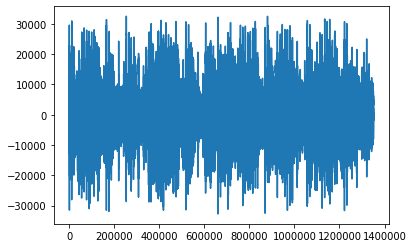

In [118]:
import matplotlib.pyplot as plt

plt.plot(data)